In [ ]:
#https://r-gaurav.github.io/2024/01/04/Building-And-Training-Spiking-Neural-Networks-From-Scratch.html

In [3]:
!pip install nengo nengo-extras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.3/542.3 kB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 9.2 MB/s eta 0:00:00


In [4]:
# implementacija jednog neurona
class IF_neuron(object):
  def __init__(self, v_thr=1.0):
    """
    Args:
      v_thr <int>: Threshold voltage of the IF neuron, default 1.0 .
    """
    self._v_thr = v_thr
    self._v = 0

  def encode_input_and_spike(self, inp):
    """
    Integrates the input and produces a spike if the IF neuron's voltage reaches
    or crosses threshold.

    Args:
      inp <float>: Scalar input to the IF neuron.
    """
    self._v = self._v + inp
    if self._v >= self._v_thr:
      self._v = 0 # Reset the voltage and produce a spike.
      return 1.0 # Spike.
    elif self._v < 0: # Rectify the voltage if it is negative.
      self._v = 0

    return 0 # No spike.

In [5]:
# Import necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from nengo_extras.plot_spikes import plot_spikes

# Create one spiking neuron and encode a random input signal.
if_neuron = IF_neuron(v_thr=1) # Instantiate a neuron.
T = 100 # Set the duration of input signal in time-steps.
inp_signal = 2*(0.5 - np.random.rand(T)) # Generate signal.

spikes = []
for t in range(T): # Execute the IF neuron for the entire duration of the input.
  spikes.append(if_neuron.encode_input_and_spike(inp_signal[t]))
spikes = np.array(spikes).reshape(-1, 1)

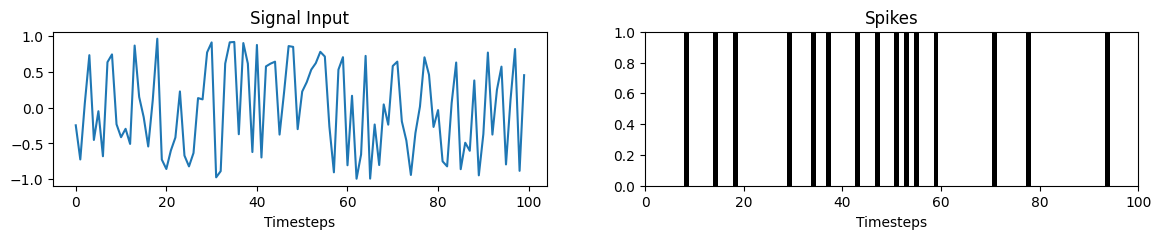

In [6]:
plt.figure(figsize=(14, 2))
plt.subplot(1, 2, 1)
plt.plot(inp_signal)
plt.title("Signal Input")
plt.xlabel("Timesteps");
plt.subplot(1, 2, 2)
plt.title("Spikes")
plot_spikes(np.arange(0, T), spikes)
plt.xlabel("Timesteps");
plt.xlim([0, 100]);

In [7]:
import torch
from abc import abstractmethod
import numpy as np
import torchvision

V_THR = 1.0
DEVICE = "cpu" # Change it to "cuda:0" if you have an NVIDIA-GPU.
BATCH_SIZE = 500 # Change it to suit your memory availability.
TAU_CUR = 1e-3 # Time constant of current decay.

In [8]:
class BaseSpkNeuron(object):
  def __init__(self, n_neurons):
    """
    Args:
      n_neurons: Number of spiking neurons.
      v_thr <int>: Threshold voltage.
    """
    self._v = torch.zeros(BATCH_SIZE, n_neurons, device=DEVICE)
    self._v_thr = torch.as_tensor(V_THR)

  def update_voltage(self, c):
    """
    Args:
      c <float>: Current input to update the voltage.
    """
    self._v = self._v + c
    mask = self._v < 0 # Mask to rectify the voltage if negative.
    self._v[mask] = 0

  def re_initialize_voltage(self):
    """
    Resets all the neurons' voltage to zero.
    """
    self._v = torch.zeros_like(self._v)

  def reset_voltage(self, spikes):
    """
    Reset the voltage of the neurons which spiked to zero.
    """
    mask = spikes.detach() > 0
    self._v[mask] = 0

    def spike_and_reset_voltage(self):
        # 1️⃣ Detektiraj spikeove: 1 ako je voltage >= threshold
        spikes = (self._v >= self._v_thr).float()

        # 2️⃣ Resetiraj voltage onih neurona koji su spikeali
        self.reset_voltage(spikes)

        # 3️⃣ Vrati spike tensor
        return spikes


In [9]:
class SrgtDrtvSpike(torch.autograd.Function):
  """
  This class implements the spiking function for the forward pass along with its
  surrogate-derivative in the backward pass.
  """
  scale = 5

  @staticmethod
  def forward(ctx, x):
    """
    Computes the spikes and returns it.

    Args:
      ctx: is the context object.
      x: is the input of the spiking function - Heaviside step function. The input
        to this function should be `v(t) - v_thr`, i.e. S(v(t)) = H(v(t) - v_thr).
    """
    ctx.save_for_backward(x)
    out = torch.zeros_like(x)
    out[x >= 0] = 1.0
    return out

  @staticmethod
  def backward(ctx, grad_output):
    """
    Computes the local gradient to be propagated back. Note that the local
    gradient = gradient of the forward function * grad_output. Here the forward
    function is estimated as the fast sigmoid function: x/(1+|x|), whose gradient
    is 1/((1+|x|)^2).

    Args:
      ctx: is the context object whose stored values would be used to calculate
        local gradient.
      grad_output: is the gradient output received from the previous layer.
    """
    x, = ctx.saved_tensors
    grad_input = grad_output.clone()
    local_grad = grad_output * 1.0/((1.0 + torch.abs(x)*SrgtDrtvSpike.scale)**2)
    return local_grad

spike_func = SrgtDrtvSpike.apply

In [10]:
class SpkEncoderLayer(BaseSpkNeuron):
  def __init__(self, n_neurons, gain=1.0, bias=0.0):
    """
    Args:
      n_neurons: Number of spiking neurons.
      gain <int>: Gain value of the neuron.
      bias <int>: Bias value of the neuron.
    """
    super().__init__(n_neurons)
    self._gain = gain
    self._bias = bias

  def spike_and_reset_voltage(self):
    delta_v = self._v - self._v_thr
    spikes = torch.zeros_like(delta_v)
    spikes[delta_v >= 0] = 1.0
    self.reset_voltage(spikes)

    return spikes

  def encode(self, x_t):
    J = self._gain * x_t + self._bias
    self.update_voltage(J)
    spikes = self.spike_and_reset_voltage()

    return spikes

In [11]:
class SpkHiddenLayer(BaseSpkNeuron, torch.nn.Module):
  def __init__(self, n_prev, n_hidn, dt=1e-3):
    """
    Args:
      n_prev <int>: Number of neurons in the previous layer.
      n_hidn <int>: Number of neurons in this hidden layer.
      dt <float>: Delta t to determine the current decay constant.
    """
    BaseSpkNeuron.__init__(self, n_hidn)
    torch.nn.Module.__init__(self)
    self._c = torch.zeros(BATCH_SIZE, n_hidn, device=DEVICE)
    self._c_decay = torch.as_tensor(np.exp(-dt/TAU_CUR))
    self._fc = torch.nn.Linear(n_prev, n_hidn, bias=False)
    self._fc.weight.data = torch.empty(
        n_hidn, n_prev, device=DEVICE).normal_(mean=0, std=2/np.sqrt(n_prev))

  def re_initialize_neuron_states(self):
    self.re_initialize_voltage()
    self._c = torch.zeros_like(self._c)

  def spike_and_reset_voltage(self): # Implement the abstract method.
    delta_v = self._v - self._v_thr
    spikes = spike_func(delta_v)
    self.reset_voltage(spikes)

    return spikes

  def forward(self, x_t):
    x_t = self._fc(x_t)
    self._c = self._c_decay*self._c + x_t
    self.update_voltage(self._c)
    spikes = self.spike_and_reset_voltage()

    return spikes


In [12]:
class SpkOutputLayer(SpkHiddenLayer):
  def __init__(self, n_prev, n_otp=10):
    """
    Args:
      n_prev <int>: Number of neurons in the previous layer.
      n_otp <int>: Number of classes in the output layer (or the dataset).
    """
    super().__init__(n_prev, n_otp)

In [13]:
class DenseSNN(torch.nn.Module):
  def __init__(self, n_ts):
    """
    Instantiates the DenseSNN class comprising of Spiking Encoder and Hidden
    layers.

    Args:
      n_ts <int>: Number of simualtion time-steps.
    """
    super().__init__()
    self.n_ts = n_ts
    self.enc_lyr = SpkEncoderLayer(n_neurons=784) # Image to Spike Encoder layer.
    self.hdn_lyrs = torch.nn.ModuleList()
    self.hdn_lyrs.append(SpkHiddenLayer(n_prev=784, n_hidn=1024)) # 1st Hidden Layer.
    self.hdn_lyrs.append(SpkHiddenLayer(n_prev=1024, n_hidn=512)) # 2nd Hidden Layer.
    self.otp_lyr = SpkOutputLayer(n_prev=512, n_otp=10)

  def _forward_through_time(self, x):
    """
    Implements the forward function through all the simulation time-steps.

    Args:
      x <Tensor>: Batch input of shape: (batch_size, 784). Note: 28x28 = 784.
    """
    all_ts_out_spks = torch.zeros(BATCH_SIZE, self.n_ts, 10) # #Classes = 10.
    for t in range(self.n_ts):
      spikes = self.enc_lyr.encode(x)
      for hdn_lyr in self.hdn_lyrs:
        spikes = hdn_lyr(spikes)
      spikes = self.otp_lyr(spikes)
      all_ts_out_spks[:, t] = spikes

    return all_ts_out_spks

  def forward(self, x):
    """
    Implements the forward function.

    Args:
      x <Tensor>: Batch input of shape: (batch_size, 784). Note: 28x28 = 784.
    """
    # Re-initialize the neuron states.
    self.enc_lyr.re_initialize_voltage()
    for hdn_lyr in self.hdn_lyrs:
      hdn_lyr.re_initialize_neuron_states()
    self.otp_lyr.re_initialize_neuron_states()

    # Do the forward pass through time, i.e., for all the simulation time-steps.
    all_ts_out_spks = self._forward_through_time(x)
    return all_ts_out_spks

In [14]:
from tqdm import tqdm

class TrainEvalDenseSNNVerbose(object):
    def __init__(self, n_ts=25, epochs=10):
        self.epochs = epochs
        self.loss_function = torch.nn.CrossEntropyLoss()
        self.model = DenseSNN(n_ts=n_ts).to(DEVICE)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        # MNIST loaders
        self.train_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(root='./data', train=True, download=True,
                                       transform=torchvision.transforms.ToTensor()),
            batch_size=BATCH_SIZE, shuffle=True
        )
        self.test_loader = torch.utils.data.DataLoader(
            torchvision.datasets.MNIST(root='./data', train=False, download=True,
                                       transform=torchvision.transforms.ToTensor()),
            batch_size=BATCH_SIZE, shuffle=False
        )

    # ---------------- Training ----------------
    def train(self, epoch):
        self.model.train()
        all_true_ys, all_pred_ys = [], []
        all_batches_loss = []

        train_iter = tqdm(self.train_loader, desc=f"Epoch {epoch} Training", leave=False)
        for i, (trn_x, trn_y) in enumerate(train_iter, 1):
            trn_x = trn_x.flatten(start_dim=1).to(DEVICE)
            trn_y = trn_y.to(DEVICE)

            # Forward
            all_ts_out_spks = self.model(trn_x)
            mean_spk_rate = torch.mean(all_ts_out_spks, dim=1)
            preds = torch.argmax(mean_spk_rate, dim=1)

            all_true_ys.extend(trn_y.detach().cpu().numpy().tolist())
            all_pred_ys.extend(preds.detach().cpu().numpy().tolist())

            # Loss + backward
            loss_value = self.loss_function(mean_spk_rate, trn_y)
            all_batches_loss.append(loss_value.item())
            self.optimizer.zero_grad()
            loss_value.backward()
            self.optimizer.step()

            # Update tqdm bar sa batch loss
            train_iter.set_postfix(batch=i, batch_loss=loss_value.item())

        trn_acc = np.mean(np.array(all_true_ys) == np.array(all_pred_ys))
        return trn_acc, np.mean(all_batches_loss)

    # ---------------- Evaluation ----------------
    def eval(self, epoch):
        self.model.eval()
        all_true_ys, all_pred_ys = [], []

        test_iter = tqdm(self.test_loader, desc=f"Epoch {epoch} Eval", leave=False)
        with torch.no_grad():
            for i, (tst_x, tst_y) in enumerate(test_iter, 1):
                tst_x = tst_x.flatten(start_dim=1).to(DEVICE)
                tst_y = tst_y.to(DEVICE)

                all_ts_out_spks = self.model(tst_x)
                mean_spk_rate = torch.mean(all_ts_out_spks, dim=1)
                preds = torch.argmax(mean_spk_rate, dim=1)

                all_true_ys.extend(tst_y.detach().cpu().numpy().tolist())
                all_pred_ys.extend(preds.detach().cpu().numpy().tolist())

                # Update tqdm bar
                test_iter.set_postfix(batch=i)

        tst_acc = np.mean(np.array(all_true_ys) == np.array(all_pred_ys))
        return tst_acc

    # ---------------- Full Train+Eval loop ----------------
    def train_eval(self):
        for epoch in range(1, self.epochs + 1):
            trn_acc, mean_loss = self.train(epoch)
            tst_acc = self.eval(epoch)
            print(f"Epoch {epoch}/{self.epochs} | Train Acc: {trn_acc*100:.2f}% | "
                  f"Train Loss: {mean_loss:.4f} | Test Acc: {tst_acc*100:.2f}%")



In [15]:
trev_model = TrainEvalDenseSNNVerbose(n_ts=25, epochs=10)
trev_model.train_eval()

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.33MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 125kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.3MB/s]


Epoch 1/10 | Train Acc: 88.41% | Train Loss: 1.6092 | Test Acc: 94.29%


Epoch 2/10 | Train Acc: 95.24% | Train Loss: 1.5380 | Test Acc: 95.47%


Epoch 3/10 | Train Acc: 96.56% | Train Loss: 1.5233 | Test Acc: 96.44%


Epoch 4/10 | Train Acc: 97.36% | Train Loss: 1.5157 | Test Acc: 96.82%


Epoch 5/10 | Train Acc: 97.92% | Train Loss: 1.5106 | Test Acc: 97.08%


Epoch 6/10 | Train Acc: 98.15% | Train Loss: 1.5081 | Test Acc: 97.29%


Epoch 7/10 | Train Acc: 98.45% | Train Loss: 1.5049 | Test Acc: 97.32%


Epoch 8/10 | Train Acc: 98.67% | Train Loss: 1.5032 | Test Acc: 97.28%


Epoch 9/10 | Train Acc: 98.86% | Train Loss: 1.5017 | Test Acc: 97.67%


Epoch 10/10 | Train Acc: 99.05% | Train Loss: 1.5001 | Test Acc: 97.66%
